In [1]:
#########################################
# Chargement des bibliothèques          #
#########################################
import os
import pandas
import pandas_profiling
import numpy
from datetime import date,datetime,timedelta
import pylab
from pymongo import MongoClient
from pprint import pprint
from pandas import DataFrame
import matplotlib.pyplot  as pyplot
import seaborn
# Désactivation des avertissements : pb mémoire, packages obsolètes, ...
import warnings
warnings.filterwarnings('ignore')

# paramétrage des options
pandas.set_option('display.max_rows', 20)
pandas.set_option('display.max_columns', 100)
pandas.set_option('display.width', 500)
%matplotlib inline

path ="/home/user/Documents/STA211-Datamining/Projet_STA"
os.chdir(path)


## Récupération des données et selection des variables


Les données sont stockées dans une base MongoDB réalisée lors des exercices de l'UE NFE204.

In [2]:
#########################################
# Chargement des données depuis MongoDB #
#########################################

# connect to MongoDB, change the << MONGODB URL >> to reflect your own connection string
client = MongoClient('localhost:27017')
db=client.airbnb

#1ère sélection des variables en fonction du taux de remplissage et des valeurs possibles

#rec = db.listings.find({})
#airbnb_complet = DataFrame(list(rec))
#profile = pandas_profiling.ProfileReport(airbnb_complet)
#profile.to_file(outputfile='airbnb_initial.html')
#del airbnb_complet

La sélection des variables est réalisée en fonction de l'analyse monovariée générée à partir de la librairie pandas-profiling.

http://htmlpreview.github.io/?https://github.com/ddupontDS/project-ds/blob/master/STA211/Analyse/airbnb_initial.html



In [3]:
#Suppression des données de type texte (à analyser sur le projet RCP216 avec les données de type commentaires ?)
#suppression egalement de toutes url : liens vers annonce, photos, propriétaire
#Puis 1ère sélection des variables en fonction du taux de remplissage et des valeurs possibles issues de pandas-profiling

# Je fais le choix métier de considérer que les appartements n'ayant pas de commentaires ni de note ne sont pas intéressants dans le cadre de l'étude
# En effet, soit ils n'ont jamais été loués, soit si faiblement que personne n'a commenté l'appartement

rec = db.listings.find({"$and" : [ {"number_of_reviews" :{"$gt": 0}},{"review_scores_rating": {"$ne" : None}},{"review_scores_accuracy": {"$ne" : None}},
                                 {"review_scores_cleanliness": {"$ne" : None}},{"review_scores_checkin": {"$ne" : None}},
                                 {"review_scores_communication": {"$ne" : None}},{"review_scores_location": {"$ne" : None}},
                                  {"review_scores_value": {"$ne" : None}} ] },
{"_id" : 1, # id de l'annonce, conservé comme index de ligne et pour pouvoir recroiser avec d'autres extractions si nécéssaire. 
            # Cet ID permet également, si l'annonce est toujours en ligne d'y accéder sur le site AirBnB de la manière suivante : https://www.airbnb.com/rooms/_id
#    "last_scraped" : 1, #date de récupération de lannonce => sur 3 jours en Avril 2017
    "name" : 1, # permet d'avoir un descriptif succint lors de l'interprétation des données
#   "experiences_offered" : 1, que la valeur None
#   "notes" : 1,#texte à analyser en textmining => infos sur Agence, professionnel ...
    "host_id" : 1, #identifiant du propriétaire
#    "host_name" : 1, # que des prénoms à utiliser en textmining pour voir si Host se retrouve dans les commentaires ?
    "host_since" : 1, #date à transformer en durée  pour déterminer une ancienneté?
#    "host_location" : 1, #pas très intéréssant car grande majorité sur Paris et pour le reste très dispersé
#    "host_response_time" : 1, # rapidité de réponse; on garde plutôt la variable suivante pour savoir si le propriétaire répond au non; à recoder en binaire
    "host_response_rate" : 1, # taux de réponse
    "host_is_superhost" : 1, # True/False
#    "host_neighbourhood" : 1, #zone de texte
#    "host_listings_count" : 1, # nombre d'appartement  quasiment identique à la variable calculated_host_listings_count
#    "host_total_listings_count" : 1, #pas de différence avec le précédent
#    "host_verifications" : 1, #difficile à analyser on garde la valeur suivante
    "host_identity_verified" : 1,# True/False
#    "neighbourhood" : 1, Zone de texte
#     "neighbourhood_cleansed" : 1,
    "zipcode" : 1, # à nettoyer car caractère bizarres
    "latitude" : 1, #conservé pour représentation carto
    "longitude" : 1,#conservé pour représentation carto
#    "is_location_exact" : 1,
    "property_type" : 1, # 95% Appartements - intéressant pour voir si les autres sont atypiques
    "room_type" : 1, # 85% où appartement complet, sinon chambre privée ou partagée
    "accommodates" : 1, #entre 1 et 16 pièce => recodage en qual ?
    "bathrooms" : 1, #entre 0 et 8 mais Q4 toujours à 1 => recodage en qual 0,1,plusieurs
    "bedrooms" : 1, #entre 0 et 10 mais Q4 toujours à 1 => recodage en qual 0,1,plusieurs
    "beds" : 1, #entre 1 et 16 mais Q4 toujours à 2 => recodage en qual 1,2,plus de 2
    "bed_type" : 1, #regroupement des valeurs faibles
#    "square_feet" :1, #conversion en m² et passage des 0 à NaN => inutile que 4% des cas renseignés
    "price" : 1, #conversion en nombre et passage des 0 à NaN
#    "weekly_price" : 1,# trop de valeurs manquantes; conversion en nombre et passage des 0 à NaN vérifier si complement des NaN Price
#   "monthly_price" : 1,#trop de valeurs manquantes; conversion en nombre et passage des 0 à NaN vérifier si complement des NaN Price
#    "security_deposit" : 1,# 40.7% missing values
    "cleaning_fee" : 1,#conversion en nombre et passage des 0 à NaN
#    "guests_included" : 1, #???
#    "extra_people" : 1,#conversion en nombre et passage des 0 à NaN
#    "minimum_nights" : 1, #difficile à interpréter
#    "maximum_nights" : 1,#difficile à interpréter
    "availability_30" : 1, #découpage en quantile
    "availability_60" : 1,#découpage en quantile
    "availability_90" : 1,#découpage en quantile
    "availability_365" : 1,#découpage en quantile
    "number_of_reviews" : 1, #nombre de commentaire => on garde les 0
    "first_review" : 1, #date à transformer en nb de mois pour déterminer une ancienneté?
    "last_review" : 1, #date à transformer en nb de mois pour déterminer une ancienneté?
    "review_scores_rating" : 1, #notes
    "review_scores_accuracy" : 1,#notes
    "review_scores_cleanliness" : 1,#notes
    "review_scores_checkin" : 1,#notes
    "review_scores_communication" : 1,#notes
    "review_scores_location" : 1,#notes
    "review_scores_value" : 1,#notes
#    "requires_license" : 1, #toujours à False
#    "jurisdiction_names" : 1, #toujours Paris
    "instant_bookable" : 1,#True/False ; peux identifier des loeurs professionnels ?
    "cancellation_policy" : 1, #regroupement des faibles modalités
#    "require_guest_profile_picture" : 1, #True/False pas d'intérêt 
#    "require_guest_phone_verification" : 1,#True/False pas d'interêt
    "calculated_host_listings_count" : 1, #permet de voir les multi-détentions dans l'échantillon
    "reviews_per_month":1 #nombre de commentaires moyen par mois
})

airbnb = DataFrame(list(rec))

#41323 rows et 37 variables


In [4]:
airbnb.shape

(41323, 37)

In [2]:
#après ce chargement des données, j'enregistre le fichier pous ne pas avoir à se reconnecter à MongoDB
#airbnb.to_json('airbnb_V1.json',orient='records',force_ascii = False)
airbnb = pandas.read_json('airbnb_V1.json')

In [6]:
profile = pandas_profiling.ProfileReport(airbnb)
profile.to_file(outputfile='airbnb_V0.html')

Le résultat des statistiques descriptives après suppression des variables inutilisées est visible via le lien suivant :
http://htmlpreview.github.io/?https://github.com/ddupontDS/project-ds/blob/master/STA211/Analyse/airbnb_V0.html

## Recodage et typage des variables
Suivant les types et la répartition des valeurs, on regroupe des modalités et/ou transforme le type des données

In [3]:
####################################
# Recodage et typage des variables #
####################################

#recodage de la variable accommodates => pas en quartile car intérêt de conserver le type d'appart.
def group_accommodates (x) : 
    val = "X" 
    if x==1 :
        val = "T1" 
    elif x==2 :
        val = "T2"
    elif x==3 :
        val = "T3"
    elif x==4 :
        val = "T4"
    else :
        val = "T5+"
    return val
airbnb["accommodates"]=airbnb["accommodates"].apply(group_accommodates)
airbnb["accommodates"]=pandas.Categorical(airbnb["accommodates"],ordered=True)

#Recodage bathrooms
def group_bathrooms (x) : 
    val = "X" 
    if x==0 :
        val = "1-None" 
    elif x==1 :
        val = "2-One"
    else :
        val = "3-Many"
    return val
airbnb["bathrooms"]=airbnb["bathrooms"].apply(group_bathrooms)
airbnb["bathrooms"]=pandas.Categorical(airbnb["bathrooms"],ordered=True)

#Recodage bed_type
def group_bed_type (x) : 
    val = "X" 
    if x=="Real Bed" :
        val = "Bed" 
    elif x=="Pull-out Sofa" :
        val = "Sofa"
    else :
        val = "Other"
    return val
airbnb["bed_type"]=airbnb["bed_type"].apply(group_bed_type)
airbnb["bed_type"]=pandas.Categorical(airbnb["bed_type"],ordered=True)

#Recodage bedrooms
def group_bedrooms (x) : 
    val = "X" 
    if x==0 :
        val = "1-None" 
    elif x==1 :
        val = "2-One"
    else :
        val = "3-Many"
    return val
airbnb["bedrooms"]=airbnb["bedrooms"].apply(group_bedrooms)
airbnb["bedrooms"]=pandas.Categorical(airbnb["bedrooms"],ordered=True)
#Recodage beds
def group_beds (x) : 
    val = "X" 
    if x==1 :
        val = "1-One" 
    elif x==2 :
        val = "2-Two"
    else :
        val = "3-More_2"
    return val
airbnb["beds"]=airbnb["beds"].apply(group_beds)
airbnb["beds"]=pandas.Categorical(airbnb["beds"],ordered=True)

#Recodage calculated_host_listings_count
def group_calculated_host_listings_count (x) : 
    val = "X" 
    if x==1 :
        val = "1-One" 
    elif x==2 :
        val = "2-Two"
    elif x==3 :
        val = "3-Three"
    else :
        val = "4-More_3"
    return val
airbnb["calculated_host_listings_count"]=airbnb["calculated_host_listings_count"].apply(group_calculated_host_listings_count)
airbnb["calculated_host_listings_count"]=pandas.Categorical(airbnb["calculated_host_listings_count"],ordered=True)

#regroupement des valeurs faiblement représentées
def group_cancellation_policy (x) : 
    val = "X" 
    if x=="super_strict_60" or x=="super_strict_30" :
        val = "strict" 
    else :
        val = x
    return val
airbnb["cancellation_policy"]=airbnb["cancellation_policy"].apply(group_cancellation_policy)
airbnb["cancellation_policy"]=pandas.Categorical(airbnb["cancellation_policy"],ordered=True)

#pour transformer des zéro en NaN
def to_nan(x):
    val = 0
    if x==0:
        val = numpy.NaN
    else:
        val = x
    return val

#pour transformer les chaîne de caractère montant en $ en nombre
def dollar_to_number (x) : 
    val = 0 
    if x==None:
        val = None
    else :
        val = float(x.replace('$','').replace(",",""))
    return val

airbnb["cleaning_fee"]=airbnb["cleaning_fee"].apply(dollar_to_number).fillna(0)
airbnb["price"]=airbnb["price"].apply(dollar_to_number).apply(to_nan)

#Pour transformer des % en nombre
def percent_to_number (x) : 
    val = 0 
    if x==None:
        val = None
    else :
        val = int(x.replace('%',''))
    return val
airbnb["host_response_rate"]=airbnb["host_response_rate"].apply(percent_to_number).fillna(0)

#Pour définir les variables Qualitatives
airbnb["property_type"]=pandas.Categorical(airbnb["property_type"],ordered=True)
airbnb["room_type"]=pandas.Categorical(airbnb["room_type"],ordered=True)
airbnb["host_identity_verified"]=pandas.Categorical(airbnb["host_identity_verified"],ordered=True)
airbnb["host_is_superhost"]=pandas.Categorical(airbnb["host_is_superhost"],ordered=True)
airbnb["instant_bookable"]=pandas.Categorical(airbnb["instant_bookable"],ordered=True)


#NB : pour les calcul suivant on fait la comparaison des dates avec le 6 Avril 2017 qui est le jour oùu les données ont été "scrappées" sur AirBnB
#transformation de la date de 1er commentaire en nb de jours depuis le 1er commentaire
airbnb["first_review"]=airbnb["first_review"].fillna('2017-04-06')
airbnb["first_review"]=airbnb["first_review"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
airbnb["day_first_review"]=(datetime.strptime('2017-04-06', '%Y-%m-%d').date()-airbnb["first_review"]).dt.days

#transformation de la date de dernier commentaire en nb de jours depuis le dernier commentaire
airbnb["last_review"]=airbnb["last_review"].fillna('2017-04-06')
airbnb["last_review"]=airbnb["last_review"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
airbnb["day_last_review"]=(datetime.strptime('2017-04-06', '%Y-%m-%d').date()-airbnb["last_review"]).dt.days

#transformation de la date 'propriétaire depuis' en nb de jours 
airbnb["host_since"]=airbnb["host_since"].fillna('2017-04-06')
airbnb["host_since"]=airbnb["host_since"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
airbnb["day_host_since"]=(datetime.strptime('2017-04-06', '%Y-%m-%d').date()-airbnb["host_since"]).dt.days

#codage du code postal en arrondissement
airbnb['zipcode']=airbnb['zipcode'].apply(lambda x: str(str(x).replace('.0','')))
def zipcode_to_arrondissement (x) : 
    val = 99.0  #Valeur Autre 
    if x in ['75001','75002','75003','75004','75005','75006','75007','75008','75009','75010','75011','75012','75013','75014',
             '75015','75016','75017','75018','75019','75020'] :
        val = int(x[3:5])
    else :
        val=99.0
    return val
airbnb['arrondissement']=airbnb['zipcode'].apply(zipcode_to_arrondissement)
airbnb["arrondissement"]=pandas.Categorical(airbnb["arrondissement"],ordered=True)
#regroupement des valeurs pour le type de logement
r={"Apartment" :'Apartment',"Loft" :'Loft',"House" :'House',"Bed & Breakfast" :'Service',"Condominium":'Other',"Other":'Other',
   "Townhouse":'Other',"Guesthouse":'Service',"Boutique hotel" :'Service',"Boat":'Other',"Dorm":'Other',"Hostel":'Service',
   "Serviced apartment":'Service',"Cabin":'Other',"Villa":'Other',"Bungalow":'Other',"Earth House":'Other',"Igloo":'Other',
   "Treehouse":'Other',"Tipi":'Other',"Timeshare":'Other',"Camper/RV":'Other',"Cave":'Other'}
airbnb['property_type']=airbnb['property_type'].astype(str).replace(r)

#renomage des valeurs pour room_type
r={"Entire home/apt" : "Entire","Private room" : "Private", "Shared room":"Shared"}
airbnb['room_type']=airbnb['room_type'].astype(str).replace(r)

#suppression des variables recodées et inutiles pour l'analyse ultérieure
airbnb = airbnb.drop(["first_review","last_review","host_since","zipcode"],axis = 1)
airbnb = airbnb.drop(['host_id','latitude','longitude','name'],axis=1)


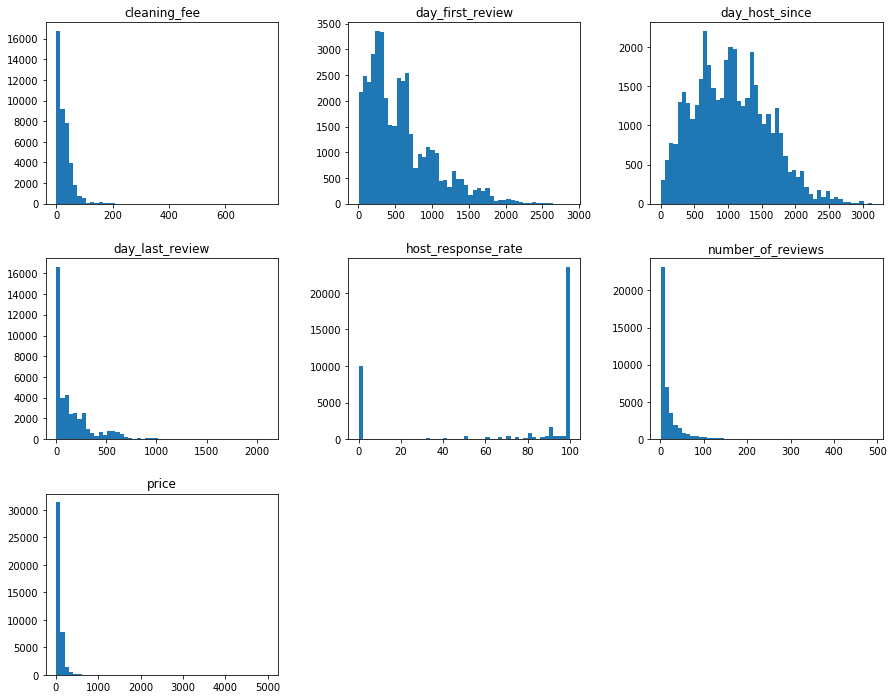

In [4]:
#Histogrammes sur les variables quantitatives
airbnb[['day_first_review','day_last_review','day_host_since','host_response_rate','number_of_reviews','price','cleaning_fee']].hist(bins=50,figsize=(15,12),grid=False);
pyplot.show()

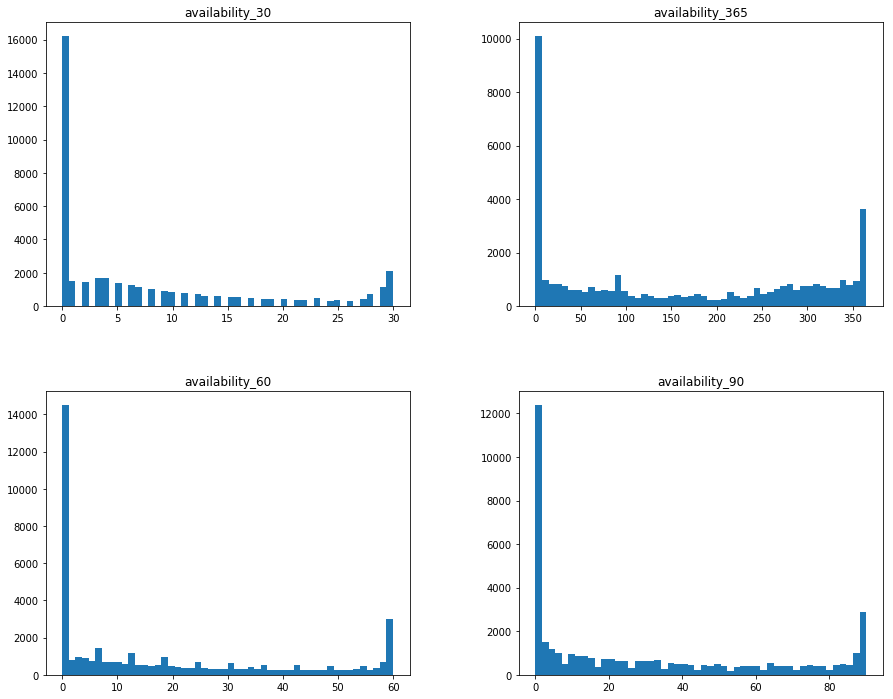

In [5]:
#Histogrammes sur les variables quantitatives disponibilité
airbnb[["availability_30","availability_60","availability_90","availability_365"]].hist(bins=50,figsize=(15,12),grid=False);
pyplot.show()

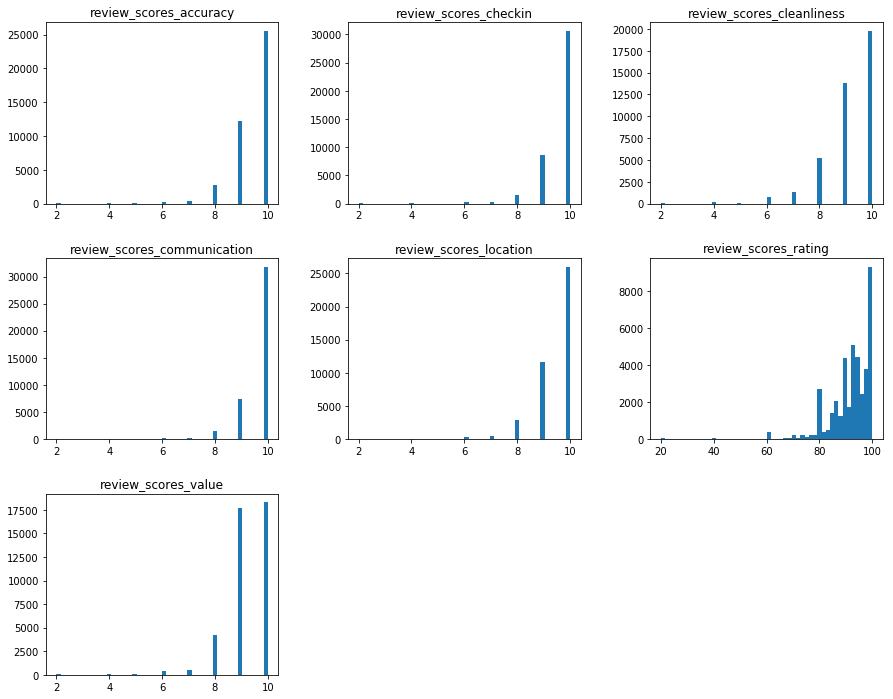

In [6]:
#Histogrammes sur les variables score
airbnb[["review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin", "review_scores_communication","review_scores_location","review_scores_value"]].hist(bins=50,figsize=(15,12),grid=False);
pyplot.show()

In [7]:
# Encore quelques transformations après analyse des données quantitatives

#mise à l'échelle de la variable review_score_rating
airbnb["review_scores_rating"]=airbnb["review_scores_rating"]/10

# Transformation en classe en fonction des quartiles

# day_first_review => transformation en fonction des quartiles : Récent (10 mois et moins), 
# Moyen (entre 10 mois et un peu plus de 2 ans) et Ancien (plus de 2 ans)
airbnb["first_review"]=pandas.qcut(airbnb["day_first_review"],3,labels=["Recent","Moyen","Ancien"])
#Récent (moins de 18 jours), Moyen (entre 18 jours et 3 mois) et Ancien (plus de 3 mois)
airbnb["last_review"]=pandas.qcut(airbnb["day_last_review"],3,labels=["Recent","Moyen","Ancien"])
#Récent (moins de 20 mois), Moyen (entre 20 mois et 33 mois) et Ancien (plus de 33 mois)
airbnb["host_since"]=pandas.qcut(airbnb["day_host_since"],3,labels=["Recent","Moyen","Ancien"])
#pour le host_response_rate, on sépare en f° de la moyenne de 70,9% en Bon et Mauvais
airbnb["host_response"]=airbnb["host_response_rate"].apply(lambda x:"Bon" if x>71  else "Mauvais")
#Faible (moins de 3 commentaires), Moyen (entre 3 et 22 commentaires) et Fort (plus de 22)
airbnb["nb_reviews"]=pandas.qcut(airbnb["number_of_reviews"],3,labels=["Faible","Moyen","Fort"])

#un peu de ménage
airbnb=airbnb.drop(['day_first_review','day_last_review','day_host_since','host_response_rate','number_of_reviews'],axis=1)
airbnb.rename(columns={'calculated_host_listings_count':'host_listings', 'cancellation_policy':'cancel_policy'}, inplace=True)

airbnb["property_type"]=pandas.Categorical(airbnb["property_type"],ordered=True)
airbnb["room_type"]=pandas.Categorical(airbnb["room_type"],ordered=True)
airbnb["host_response"]=pandas.Categorical(airbnb["host_response"],ordered=True)


## Analyse des variables Price et Cleaning_fee


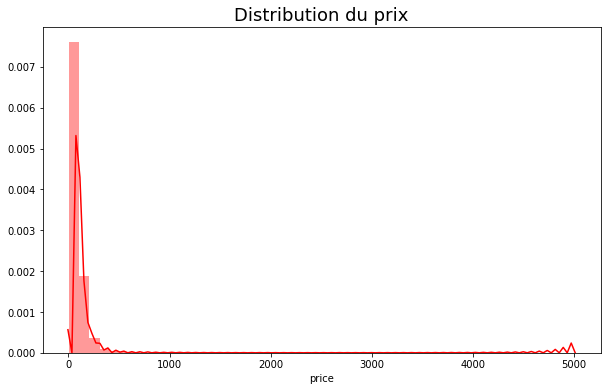

In [8]:
import seaborn
pyplot.figure(figsize=(10,6))
seaborn.distplot(airbnb['price'], color='r')
pyplot.title('Distribution du prix', fontsize=18)
pyplot.show()

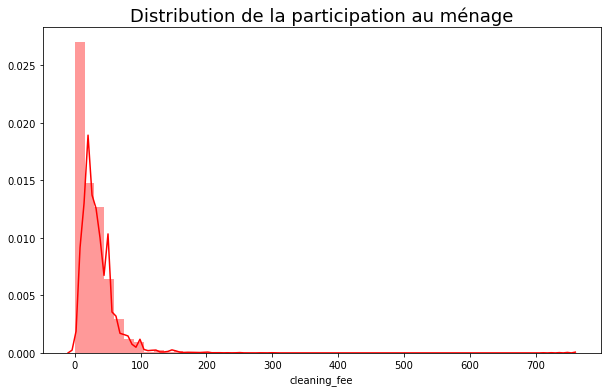

In [11]:
pyplot.figure(figsize=(10,6))
seaborn.distplot(airbnb['cleaning_fee'], color='r')
pyplot.title('Distribution de la participation au ménage', fontsize=18)
pyplot.show()

In [12]:
airbnb[['price','cleaning_fee']].describe()

,price,cleaning_fee
count,41323.000000,41323.000000
mean,93.267672,23.914793
std,80.528787,27.225241
min,8.000000,0.000000
25%,53.000000,0.000000
50%,74.000000,20.000000
75%,100.000000,36.000000
max,5000.000000,750.000000


## Traitement des valeurs manquantes
Il y a peu de valeurs manquantes dans les données => j’ai décidé de remplacer par la valeur majoritaire pour les variables qualitatives et par 0 pour les quantitatives.


In [13]:
#traitement des valeurs manquantes
airbnb["reviews_per_month"]=airbnb["reviews_per_month"].fillna(0) # que 3 missing
airbnb["host_is_superhost"]=airbnb["host_is_superhost"].fillna('f')# que 2 missing
airbnb["host_identity_verified"]=airbnb["host_identity_verified"].fillna('f')# que 2 missing


In [16]:
# 2ème passage sur l'analyse des variable pour vérifier la qualité des variables recodées
profile = pandas_profiling.ProfileReport(airbnb)
profile.to_file(outputfile='airbnb.html')

Suite au recodage et à la transformation des données on relance les statistiques descriptives à partir de la librairie pandas-profiling.

http://htmlpreview.github.io/?https://github.com/ddupontDS/project-ds/blob/master/STA211/Analyse/airbnb.html



## Analyse des données atypiques

Le point le plus "surprenant" est le prix très élevé de certaines location : jusqu'à 5000€ la nuit. Ou très faible : moins de 20 €
Le fait d'avoir supprimé les appartements sans commentaires au départ diminue le nombre de cas mais il reste encore des cas surprenants

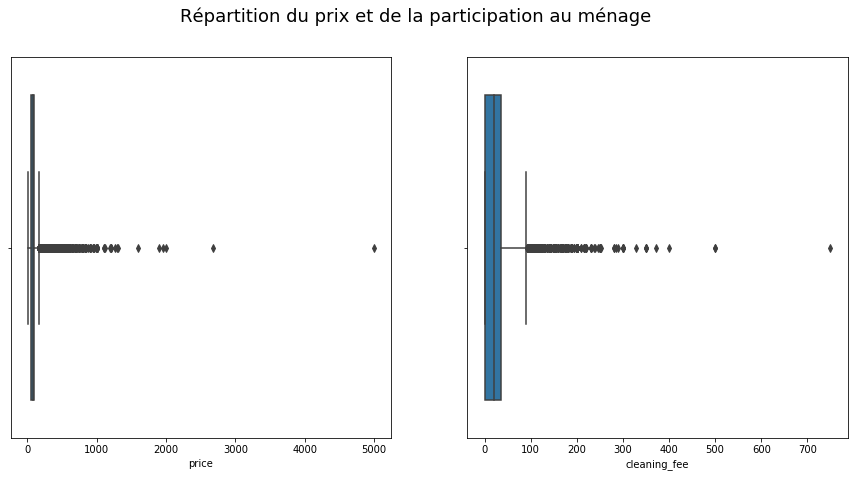

In [14]:
fig, axs = pyplot.subplots(ncols=2,figsize=(15,7))
seaborn.boxplot(x='price', data=airbnb,ax=axs[0])
seaborn.boxplot(x='cleaning_fee', data=airbnb,ax=axs[1])
pyplot.suptitle('Répartition du prix et de la participation au ménage', fontsize=18)
pyplot.show()


In [19]:
# extraction des appartements à plus de 500€ la nuit ou à moins de 10€
airbnb[numpy.logical_or(airbnb["price"]>500, airbnb["price"]<20)].to_csv('atypique.csv')
# extraction des données atypique sur le montant cleaning_fee
airbnb[airbnb["cleaning_fee"]>200].to_csv('atypique_cleaning.csv')


En analysant quelques lignes atypiques sur le prix; on voit plusieurs cas : des biens réellement d'exceptions dans des quartiers très recherchés, mais aussi des choses qui paraissent surprenantes. De même en regardant plus en détail les prix inférieur à 20€, soit les annonces n'existent plus, soit il n'y a pas de disponibilité, même si on trouve quelques cas exceptionnels de chambre chez l'habitant. => je décide de supprimer les quelques cas (10) supérieurs à 1300€ et inférieurs à 20€ (90 cas)

In [16]:
airbnb = airbnb[numpy.logical_and(airbnb["price"]<1300,airbnb["price"]>20)]
# après analyse, les 45 appartements concernés sur lcleaning_fee ne sont plus proposé à la location
# je décide de supprimer ces cas
airbnb=airbnb[airbnb["cleaning_fee"]<=200]

In [17]:
#définition d'un prix total prenant en compte le prix et le ménage
airbnb['total_price']=airbnb["price"]+airbnb["cleaning_fee"]
airbnb[['price','cleaning_fee','total_price']].describe()

,price,cleaning_fee,total_price
count,41094.000000,41094.000000,41094.000000
mean,92.886042,23.706234,116.592276
std,72.260509,25.659858,87.251874
min,21.000000,0.000000,21.000000
25%,54.000000,0.000000,65.000000
50%,75.000000,20.000000,95.000000
75%,100.000000,37.000000,139.000000
max,1290.000000,200.000000,1350.000000


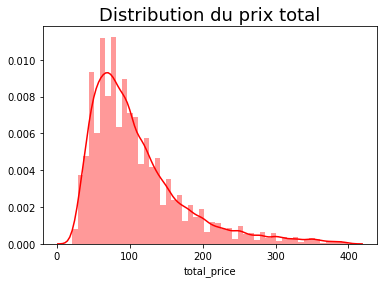

In [18]:
seaborn.distplot(airbnb[airbnb["total_price"]<400]['total_price'], color='r')
pyplot.title('Distribution du prix total', fontsize=18)
pyplot.show()

In [19]:
#définition d'une classe prix en fonction des quartiles pour faciliter la visualisation lors des analyses bi-dimensionnelles
#Les bornes des classes sont choisies pour avoir des classes à peu près équilibrées sur les 4 1ères classes
airbnb["price_level"]=pandas.cut(airbnb["total_price"],[21,60,90,130,400, 1350],labels=["Faible","Moyen","Eleve","Cher","Exorbitant"])
airbnb["price_level"].value_counts()


Moyen         10887
Cher          10532
Eleve          9825
Faible         9218
Exorbitant      622
Name: price_level, dtype: int64

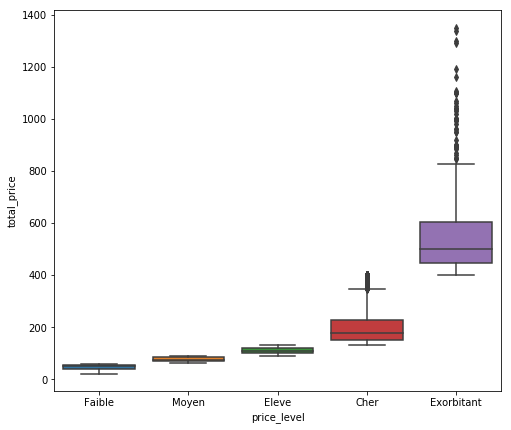

In [20]:
pyplot.figure(figsize=(8,7))
seaborn.boxplot(x='price_level', y='total_price', data=airbnb)
pyplot.show()


In [22]:
airbnb=airbnb.drop(['price','cleaning_fee'],axis=1)
#cols = list(airbnb.columns.values)
#cols
airbnb=airbnb[['_id',
 'accommodates',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'property_type',
 'room_type',
 'arrondissement',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings',
 'host_response',
 'host_since',
 'cancel_policy',
 'instant_bookable',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'first_review',
 'last_review',
 'nb_reviews',
 'review_scores_accuracy',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_rating',
 'review_scores_value',
 'reviews_per_month',
  'total_price',
  'price_level'
]]
# après cette préparation des données, j'enregistre le fichier pous ne pas avoir à le regénérer lors de la phase 
# d'analyse statistiques
airbnb.to_json('airbnb_V2.json',orient='records',force_ascii = False)


In [2]:
airbnb=pandas.read_json('airbnb_V2.json')

## Analyses bi-dimensionnelles
Recherche d'une éventuelle dépendance entre les variables qualitatives et le prix total
Pour voir les relations, 

No handles with labels found to put in legend.


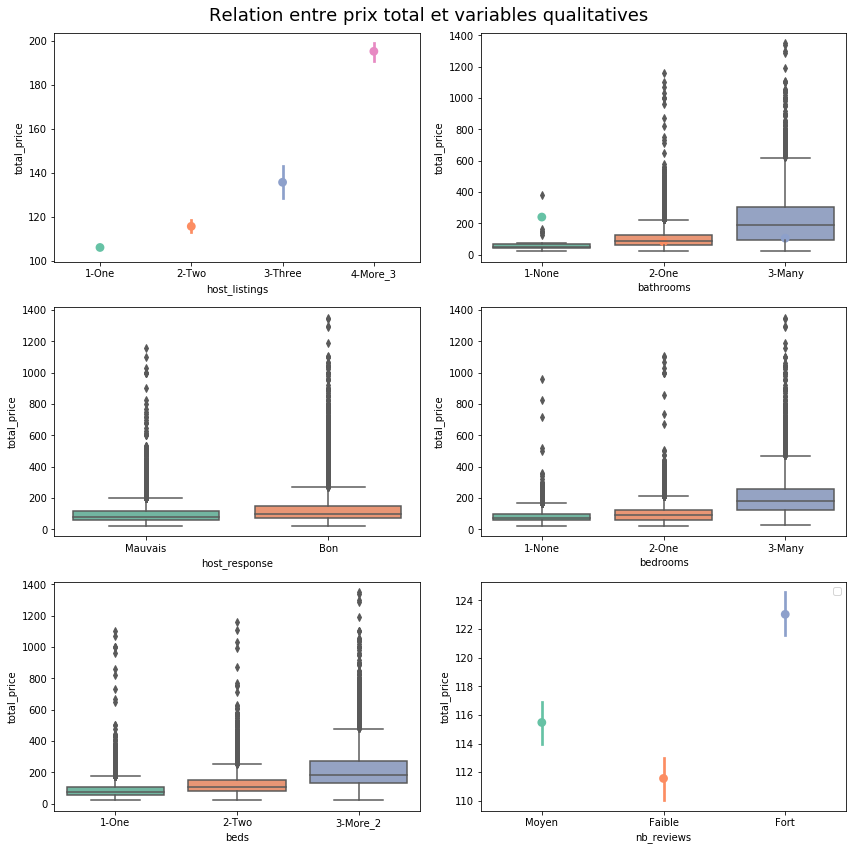

In [15]:
airbnb["host_listings"]=pandas.Categorical(airbnb["host_listings"],ordered=True)
airbnb["bathrooms"]=pandas.Categorical(airbnb["bathrooms"],ordered=True)
airbnb["bedrooms"]=pandas.Categorical(airbnb["bedrooms"],ordered=True)
airbnb["beds"]=pandas.Categorical(airbnb["beds"],ordered=True)

fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = pyplot.subplots(nrows=3, ncols=2, figsize=(12,12))
pyplot.suptitle('Relation entre prix total et variables qualitatives', fontsize=18)
seaborn.pointplot(x="host_listings", y="total_price", data=airbnb, palette="Set2", ax=ax1)
seaborn.pointplot(x='accommodates', y='total_price',palette="Set2", data=airbnb, ax=ax2)
seaborn.boxplot(x='bathrooms', y='total_price', palette="Set2",data=airbnb, ax=ax2)
seaborn.boxplot(x='host_response', y='total_price',  palette="Set2",data=airbnb, ax=ax3)
seaborn.boxplot(x='bedrooms', y='total_price', palette="Set2",data=airbnb, ax=ax4)
seaborn.boxplot(x='beds', y='total_price',  palette="Set2",data=airbnb, ax=ax5)
seaborn.pointplot(x='nb_reviews', y='total_price',  palette="Set2",data=airbnb, ax=ax6)
pyplot.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
pyplot.show()

No handles with labels found to put in legend.


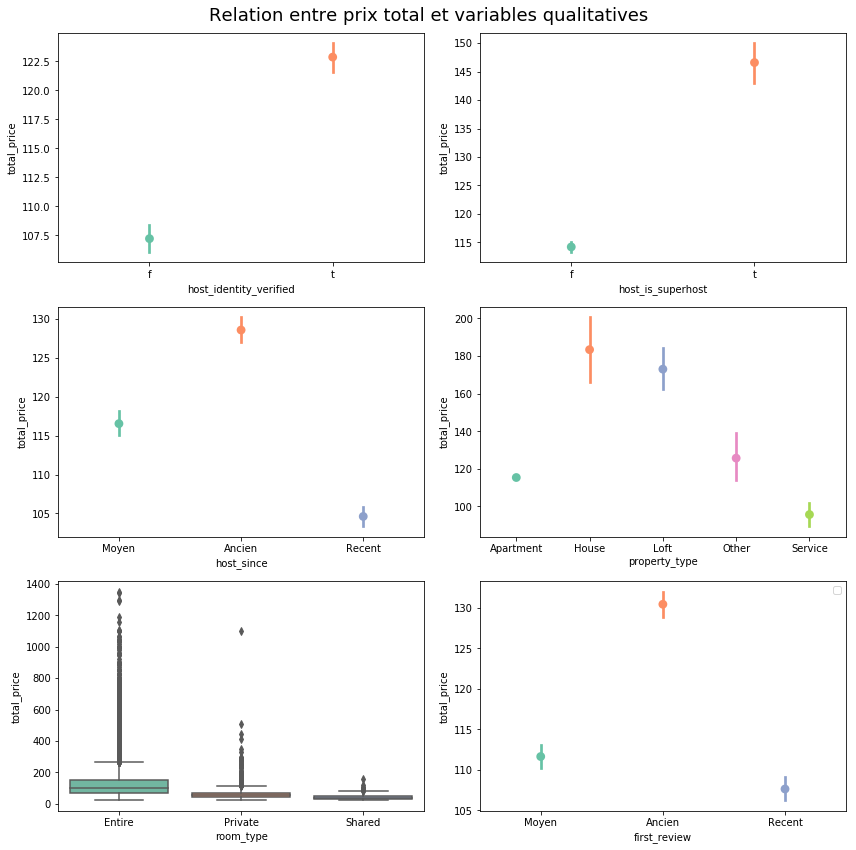

In [18]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = pyplot.subplots(nrows=3, ncols=2, figsize=(12,12))
pyplot.suptitle('Relation entre prix total et variables qualitatives', fontsize=18)
seaborn.pointplot(x='host_identity_verified', y='total_price',  palette="Set2",data=airbnb, ax=ax1)
seaborn.pointplot(x='host_is_superhost', y='total_price',  palette="Set2",data=airbnb, ax=ax2)
seaborn.pointplot(x='host_since', y='total_price', palette="Set2", data=airbnb, ax=ax3)
seaborn.pointplot(x='property_type', y='total_price', palette="Set2",data=airbnb, ax=ax4)
seaborn.boxplot(x='room_type', y='total_price',palette="Set2",data=airbnb, ax=ax5)
seaborn.pointplot(x='first_review', y='total_price',  palette="Set2",data=airbnb, ax=ax6)
pyplot.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
pyplot.show()

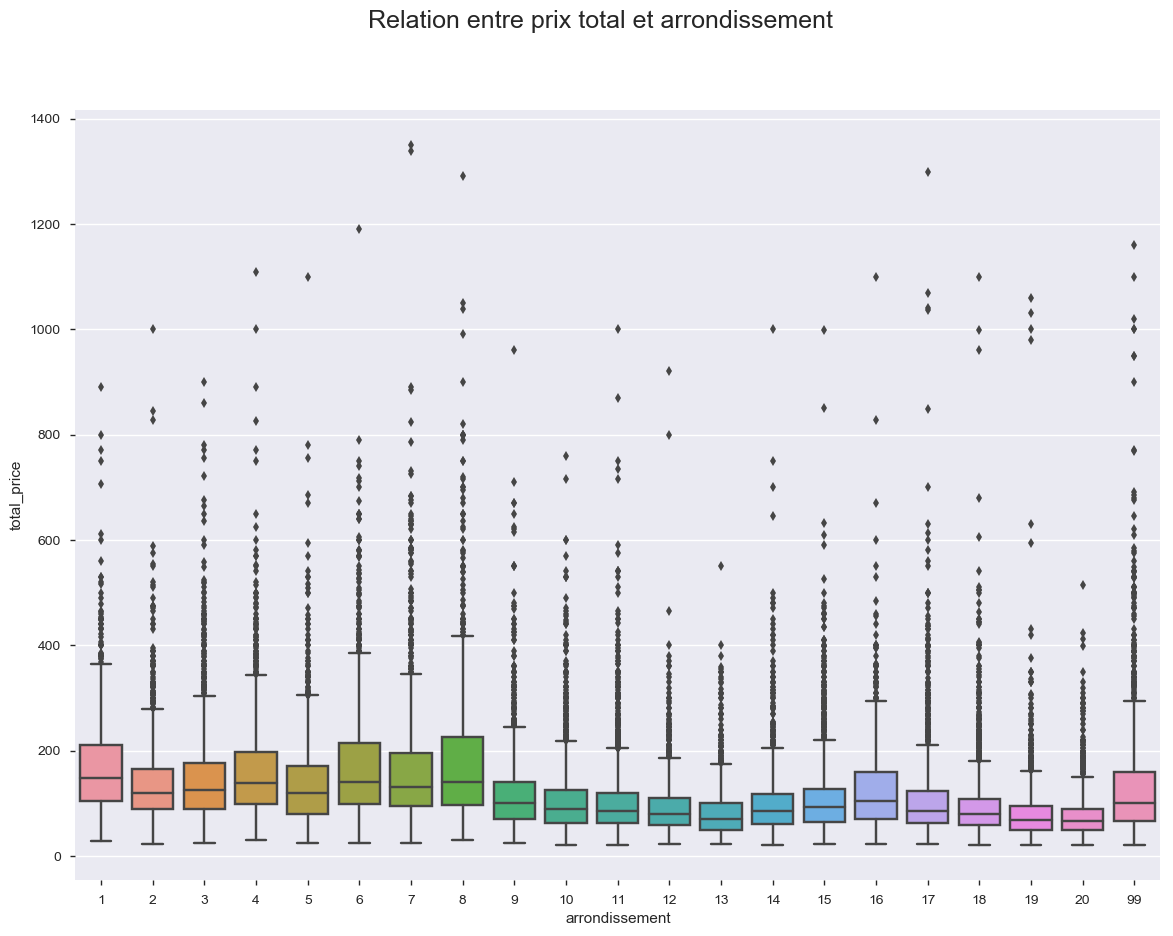

In [31]:
pyplot.figure(figsize=(14,10))
pyplot.suptitle('Relation entre prix total et arrondissement', fontsize=18)
seaborn.boxplot(x='arrondissement', y='total_price', data=airbnb)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
pyplot.show()

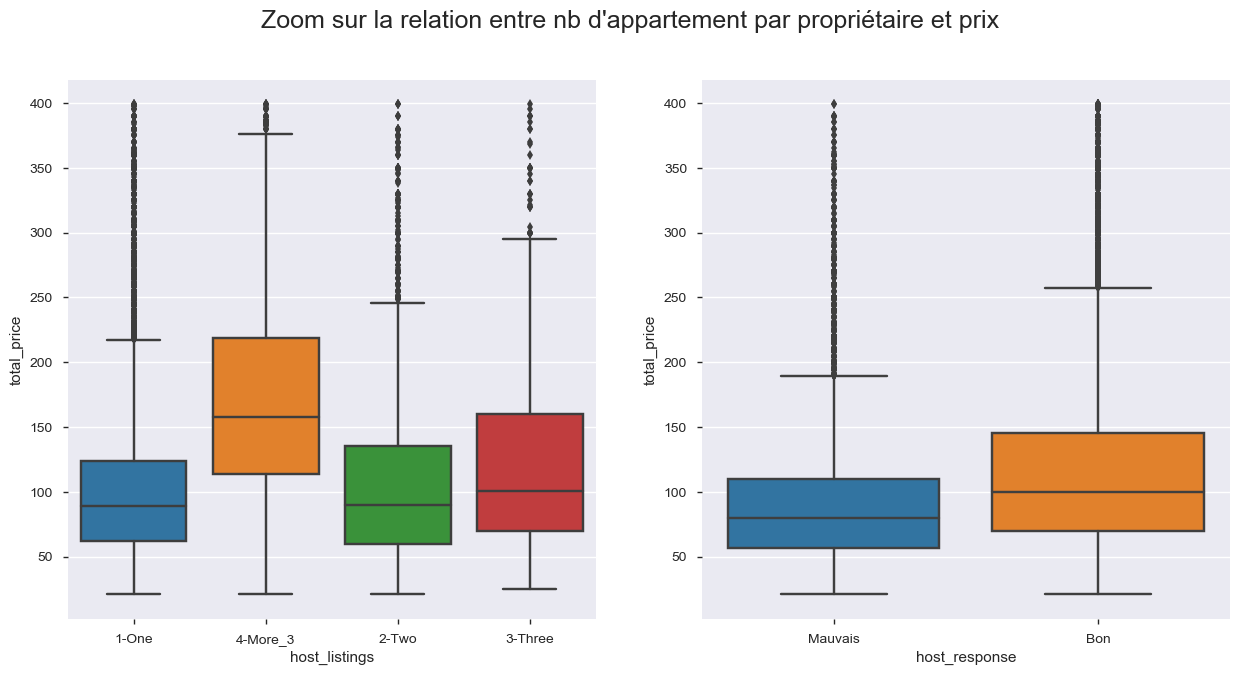

In [32]:
fig, axs = pyplot.subplots(ncols=2,figsize=(15,7))
seaborn.boxplot(x='host_listings', y='total_price', data=airbnb[airbnb["total_price"]<400],ax=axs[0])
seaborn.boxplot(x='host_response', y='total_price', data=airbnb[airbnb["total_price"]<400],ax=axs[1]),
pyplot.suptitle('Zoom sur la relation entre nb d\'appartement par propriétaire et prix', fontsize=18)
pyplot.show()


In [33]:
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

#ANOVA F Test
model = smf.ols(formula='total_price ~ host_listings', data=airbnb)
results = model.fit()
print(" Relation Prix-host_listings : F = ",round(results.fvalue,2)," p(F) = ",results.f_pvalue)

model = smf.ols(formula='total_price ~ host_response', data=airbnb)
results = model.fit()
print(" Relation Prix-host_response : F = ",round(results.fvalue,2)," p(F) = ",results.f_pvalue)
model = smf.ols(formula='total_price ~ accommodates', data=airbnb)
results = model.fit()
print(" Relation Prix-accommodates : F = ",round(results.fvalue,2)," p(F) = ",results.f_pvalue)
model = smf.ols(formula='total_price ~ host_identity_verified', data=airbnb)
results = model.fit()
print(" Relation Prix-host_identity_verified : F = ",round(results.fvalue,2)," p(F) = ",results.f_pvalue)
model = smf.ols(formula='total_price ~ cancel_policy', data=airbnb)
results = model.fit()
print(" Relation Prix-cancel_policy : F = ",round(results.fvalue,2)," p(F) = ",results.f_pvalue)
model = smf.ols(formula='total_price ~ arrondissement', data=airbnb)
results = model.fit()
print(" Relation Prix-arrondissement : F = ",round(results.fvalue,2)," p(F) = ",results.f_pvalue)

# 'bathrooms',
# 'bed_type',
# 'bedrooms',
# 'beds',
# 'property_type',

 Relation Prix-host_listings : F =  1419.55  p(F) =  0.0
 Relation Prix-host_response : F =  1061.07  p(F) =  8.118126212897865e-230
 Relation Prix-accommodates : F =  5221.91  p(F) =  0.0
 Relation Prix-host_identity_verified : F =  319.54  p(F) =  3.3952957999130246e-71
 Relation Prix-cancel_policy : F =  1820.26  p(F) =  0.0
 Relation Prix-arrondissement : F =  76.48  p(F) =  2.3095031563711656e-18


In [34]:
import statsmodels.stats.multicomp as multi

test = multi.MultiComparison(airbnb["total_price"], airbnb["accommodates"])
res = test.tukeyhsd()
print(res.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  T1     T2   30.9714  25.9138  36.0289   True 
  T1     T3   52.9869  47.2797  58.6942   True 
  T1     T4   83.5568  78.3432  88.7705   True 
  T1    T5+   187.8777 182.2554  193.5    True 
  T2     T3   22.0156  18.7314  25.2998   True 
  T2     T4   52.5855  50.2627  54.9083   True 
  T2    T5+   156.9063 153.7721 160.0406  True 
  T3     T4   30.5699   27.05   34.0898   True 
  T3    T5+   134.8908 130.7898 138.9917  True 
  T4    T5+   104.3209 100.9405 107.7013  True 
-----------------------------------------------


## Analyses multi-dimensionnelles
Analyse des variables mises de côté sur les notations et la disponibilité

En regardant la matrice de corrélations, on visualise une forte corrélation entre les notes données par les locataires.
=> il est intéressant de faire une analyse factorielle sur ces données pour éventuellement ne conserver que les axes principaux.


[0.56219243 0.11986534 0.11232767 0.06302713 0.05483782 0.05138777
 0.03636184]


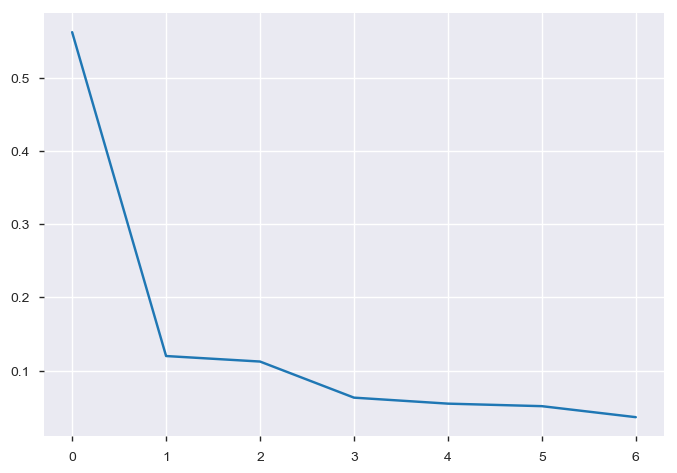

In [35]:
# Faire une ACP sur les notes
from sklearn.decomposition import PCA

# suppression des lignes n'ayant pas de note
airbnb_pca=airbnb.dropna()
# Normalisation des valeurs
d = airbnb_pca[['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value']]
data = (d - d.mean()) / d.std()

#créer un objet PCA
acp_reviews_score = PCA()
C = acp_reviews_score.fit(data).transform(data)
print(acp_reviews_score.explained_variance_ratio_)
# Eboulis des valeurs propres
pyplot.figure()
pyplot.plot(acp_reviews_score.explained_variance_ratio_)
pyplot.show()

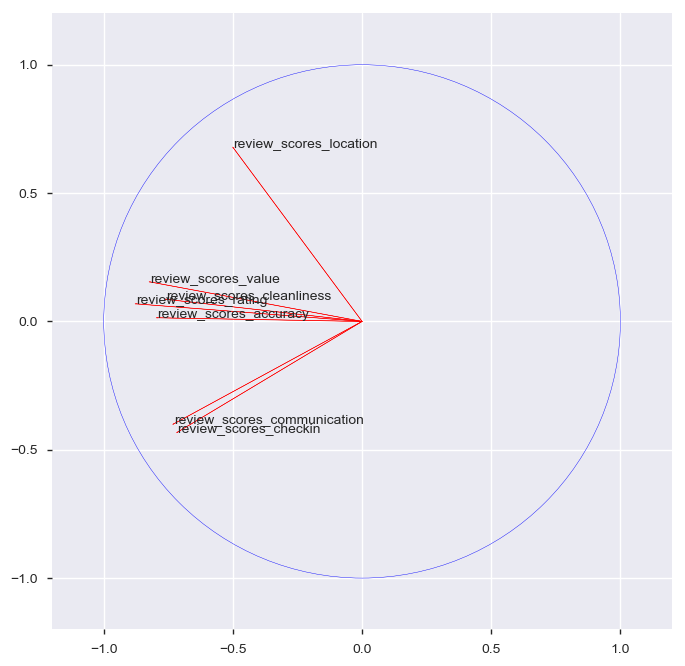

In [36]:
# coordonnées des variables
coord1=acp_reviews_score.components_[0]*numpy.sqrt(acp_reviews_score.explained_variance_[0])
coord2=acp_reviews_score.components_[1]*numpy.sqrt(acp_reviews_score.explained_variance_[1])
fig = pyplot.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, airbnb_pca[['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value']].columns):
    pyplot.text(i, j, nom)
    pyplot.arrow(0,0,i,j,color='r')
pyplot.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=pyplot.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
pylab.show()

Au vue de cette analyse, je décide de ne conserver que 3 variables de notation : une sur la localisation de l'appartement, une sur la communication du propriétaire (communication et chekin) et la dernière sur les autres notes en faisant une moyenne des différentes notes.

In [34]:
airbnb['score_location'] = airbnb['review_scores_location']
airbnb['score_communication'] = (airbnb['review_scores_communication']+airbnb['review_scores_checkin'])/2
airbnb['score_other'] = (airbnb['review_scores_accuracy']+airbnb['review_scores_cleanliness']
                         +airbnb['review_scores_rating']+airbnb['review_scores_value'])/4
airbnb = airbnb.drop(['review_scores_accuracy', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_rating', 'review_scores_value'],axis=1)
airbnb=airbnb[['_id',
 'accommodates',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'property_type',
 'room_type',
 'arrondissement',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings',
 'host_response',
 'host_since',
 'cancel_policy',
 'instant_bookable',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'first_review',
 'last_review',
 'nb_reviews',
 'score_communication',
 'score_location',
 'score_other',
 'reviews_per_month',
  'total_price',
  'price_level'
]]
airbnb.to_json('airbnb_V3.json',orient='records',force_ascii = False)


## Passage en R pour faire une AFM avec Factominer

In [19]:
%load_ext rpy2.ipython

In [21]:
%%R -w 5 -h 5 --units in -r 200
#Définition des librairies
library(jsonlite)
library(Hmisc)
library(FactoMineR)

#Chargement du jeu de données
path="/home/user/Documents/STA211-Datamining/Projet_STA/"
Airbnb<-fromJSON(paste(path,"airbnb_V3.json",sep=""))
sapply(Airbnb,class)
summary(Airbnb)


      _id           accommodates        bathrooms           bed_type        
 Min.   :    2525   Length:41094       Length:41094       Length:41094      
 1st Qu.: 3688220   Class :character   Class :character   Class :character  
 Median : 7887020   Mode  :character   Mode  :character   Mode  :character  
 Mean   : 8425822                                                           
 3rd Qu.:13304907                                                           
 Max.   :17968815                                                           
   bedrooms             beds           property_type       room_type        
 Length:41094       Length:41094       Length:41094       Length:41094      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            

In [3]:
%%R
character_vars <- lapply(Airbnb, class) == "character"
Airbnb[, character_vars] <- lapply(Airbnb[, character_vars], as.factor)
#définition de la variable arrondissement comme qualitative
Airbnb$arrondissement <- as.factor(Airbnb$arrondissement ) 
sapply(Airbnb,class)

                   _id           accommodates              bathrooms 
             "integer"               "factor"               "factor" 
              bed_type               bedrooms                   beds 
              "factor"               "factor"               "factor" 
         property_type              room_type         arrondissement 
              "factor"               "factor"               "factor" 
host_identity_verified      host_is_superhost          host_listings 
              "factor"               "factor"               "factor" 
         host_response             host_since          cancel_policy 
              "factor"               "factor"               "factor" 
      instant_bookable        availability_30       availability_365 
              "factor"              "integer"              "integer" 
       availability_60        availability_90           first_review 
             "integer"              "integer"               "factor" 
           last_revi

In [5]:
%%R
res.mfa = MFA(Airbnb[,2:29], group=c(7,1,7,4,3,4,1,1), type=c("n","n","n","c","n","c","c","n"), ncp=5, name.group=c("appart","arrondissement","host","availibility","reviews", "scores","price","price_level"),num.group.sup=c(2,5,7,8))



Call:
MFA(base = Airbnb[, 2:29], group = c(7, 1, 7, 4, 3, 4, 1, 1),  
     type = c("n", "n", "n", "c", "n", "c", "c", "n"), ncp = 5,  
     name.group = c("appart", "arrondissement", "host", "availibility",  
         "reviews", "scores", "price", "price_level"), num.group.sup = c(2,  
         5, 7, 8)) 


Eigenvalues
                       Dim.1   Dim.2   Dim.3   Dim.4   Dim.5   Dim.6   Dim.7
Variance               1.467   1.171   0.963   0.772   0.713   0.666   0.620
% of var.              9.406   7.509   6.176   4.950   4.572   4.271   3.973
Cumulative % of var.   9.406  16.916  23.092  28.042  32.614  36.884  40.858
                       Dim.8   Dim.9  Dim.10  Dim.11  Dim.12  Dim.13  Dim.14
Variance               0.588   0.581   0.574   0.504   0.484   0.442   0.441
% of var.              3.771   3.726   3.679   3.231   3.104   2.837   2.830
Cumulative % of var.  44.629  48.355  52.034  55.264  58.368  61.206  64.035
                      Dim.15  Dim.16  Dim.17  Dim.18  Dim.19 

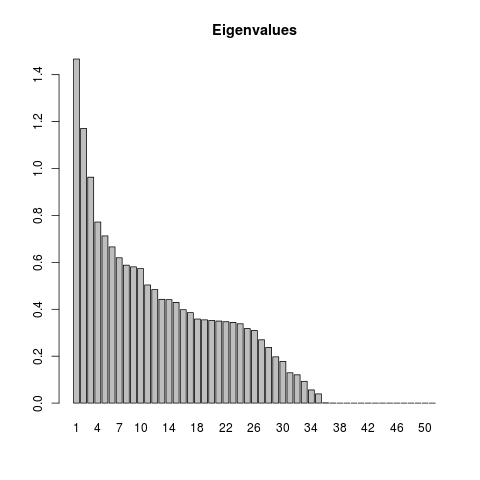

In [42]:
%%R
summary(res.mfa)
barplot(res.mfa$eig[,1],main="Eigenvalues",names.arg=1:nrow(res.mfa$eig))

In [ ]:
%%R
library(Factoshiny)
resshiny=MFAshiny(res.mfa)

## Analyse non supervisée - Classification K-means en R

In [4]:
%%R
# Chargement des bibliothèques
#Définition des librairies
library(jsonlite)
suppressPackageStartupMessages(library(Hmisc))
suppressPackageStartupMessages(library(cluster))
suppressPackageStartupMessages(library(Ecdat))
suppressPackageStartupMessages(library(compareGroups))
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(dplyr))

In [8]:
%%R
#Chargement du jeu de données
path="/home/user/Documents/STA211-Datamining/Projet_STA/"
Airbnb<-fromJSON(paste(path,"airbnb_V3.json",sep=""))
character_vars <- lapply(Airbnb, class) == "character"
Airbnb[, character_vars] <- lapply(Airbnb[, character_vars], as.factor)
#définition de la variable arrondissement comme qualitative
Airbnb$arrondissement <- as.factor(Airbnb$arrondissement ) 
sapply(Airbnb,class)
# Définition d'un échantillon de 30% pour des problèmes de mémoire
Airbnb_train <- Airbnb %>% sample_frac(0.3)
# Calcul de la matrice de distance en utilisant la métrique de Gower car données mixtes
distance_Airbnb_train<-daisy(Airbnb_train,metric = "gower")

In [9]:
%%R
set.seed(123)
# Calcul d'un K-means en 3 classes
AirBnb_classes<-kmeans(distance_Airbnb_train, centers=3)

In [11]:
%%R
# Taille de chacune des classes
table(AirBnb_classes$cluster)


   1    2    3 
4920 3103 4305 


In [12]:
%%R
#Ajout de la variable classe au jeu de données
Airbnb_train$classe <- AirBnb_classes$cluster
Airbnb_train$classe <- as.factor(Airbnb_train$classe ) 
sapply(Airbnb_train,class)

                   _id           accommodates              bathrooms 
             "integer"               "factor"               "factor" 
              bed_type               bedrooms                   beds 
              "factor"               "factor"               "factor" 
         property_type              room_type         arrondissement 
              "factor"               "factor"               "factor" 
host_identity_verified      host_is_superhost          host_listings 
              "factor"               "factor"               "factor" 
         host_response             host_since          cancel_policy 
              "factor"               "factor"               "factor" 
      instant_bookable        availability_30       availability_365 
              "factor"              "integer"              "integer" 
       availability_60        availability_90           first_review 
             "integer"              "integer"               "factor" 
           last_revi

In [13]:
%%R
# Comparaison des variables pour chacune des classes
# permet de caractériser chacune des classes
group<-compareGroups(classe~accommodates+bathrooms+bed_type+bedrooms+beds+room_type
                     +host_identity_verified+host_listings+host_response+host_since+cancel_policy
                     +instant_bookable+availability_365+availability_90+availability_60+availability_30
                     +first_review+last_review+nb_reviews
                     +price_level+total_price
                     ,data = Airbnb_train)
compare_classe<-createTable(group)
compare_classe


--------Summary descriptives table by 'classe'---------

________________________________________________________________________ 
                             1            2            3       p.overall 
                           N=4920       N=3103       N=4305              
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯ 
accommodates:                                                   <0.001   
    T1                  132 (2.68%)  155 (5.00%)  205 (4.76%)            
    T2                  2949 (59.9%) 1685 (54.3%) 1269 (29.5%)           
    T3                  512 (10.4%)  296 (9.54%)  467 (10.8%)            
    T4                  1164 (23.7%) 740 (23.8%)  1371 (31.8%)           
    T5+                 163 (3.31%)  227 (7.32%)  993 (23.1%)            
bathrooms:                                                      <0.001   
    1-None               5 (0.10%)    5 (0.16%)    8 (0.19%)             
    2-One               4768 (96.9%) 2881 (92.8%) 3366

## Génération d'un arbre de décision pour expliquer le niveau de prix

In [22]:
%%R
library(rpart)
library(rpart.plot)

#Chargement du jeu de données
path="/home/user/Documents/STA211-Datamining/Projet_STA/"
Airbnb<-fromJSON(paste(path,"airbnb_V3.json",sep=""))
sapply(Airbnb,class)
character_vars <- lapply(Airbnb, class) == "character"
Airbnb[, character_vars] <- lapply(Airbnb[, character_vars], as.factor)
#définition de la variable arrondissement comme qualitative
Airbnb$arrondissement <- as.factor(Airbnb$arrondissement ) 
sapply(Airbnb,class)
#suppression de la variable Prix total
Airbnb <- subset(Airbnb, select = -c(total_price) )
Airbnb <- na.omit(Airbnb)

In [23]:
%%R 
library(caret)
set.seed(3456)
trainIndex <- createDataPartition(Airbnb$price_level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
AirbnbTrain <- Airbnb[ trainIndex,]
AirbnbTest  <- Airbnb[-trainIndex,]


In [24]:
%%R
# Arbre sur la variable price_level
AirbnbTree <- rpart(price_level~.,data=AirbnbTrain,control=rpart.control(minsplit=50,cp = 0.005, xval=20))
#AirbnbTree <- rpart(price_level~.,data=Airbnb,control=rpart.control(minsplit=500,cp = 0.01, xval=20))
printcp(AirbnbTree)


Classification tree:
rpart(formula = price_level ~ ., data = AirbnbTrain, control = rpart.control(minsplit = 50, 
    cp = 0.005, xval = 20))

Variables actually used in tree construction:
[1] accommodates     arrondissement   availability_365 bedrooms        
[5] host_listings    room_type       

Root node error: 24159/32869 = 0.73501

n= 32869 

         CP nsplit rel error  xerror      xstd
1 0.1717786      0   1.00000 1.00000 0.0033119
2 0.0701188      1   0.82822 0.83393 0.0036552
3 0.0200339      2   0.75810 0.75810 0.0037275
4 0.0164328      3   0.73807 0.73807 0.0037386
5 0.0155843      4   0.72164 0.73016 0.0037421
6 0.0058363      6   0.69047 0.69279 0.0037515
7 0.0056501      8   0.67879 0.68269 0.0037522
8 0.0056294     10   0.66749 0.68194 0.0037522
9 0.0050000     11   0.66187 0.67395 0.0037520


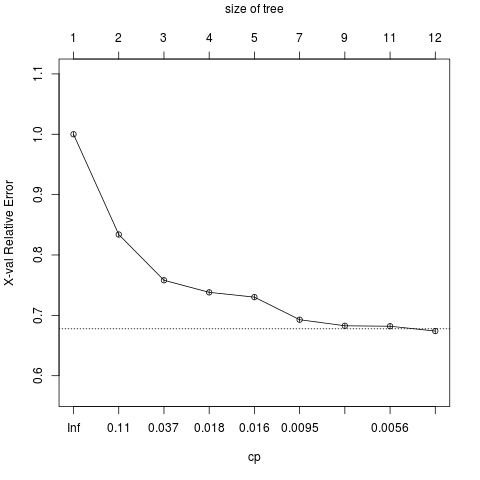

In [65]:
%%R
plotcp(AirbnbTree)

In [51]:
%%R 
sapply(AirbnbTrain,class)
sapply(AirbnbTrain,class)

                   _id           accommodates              bathrooms 
             "integer"               "factor"               "factor" 
              bed_type               bedrooms                   beds 
              "factor"               "factor"               "factor" 
         property_type              room_type         arrondissement 
              "factor"               "factor"               "factor" 
host_identity_verified      host_is_superhost          host_listings 
              "factor"               "factor"               "factor" 
         host_response             host_since          cancel_policy 
              "factor"               "factor"               "factor" 
      instant_bookable        availability_30       availability_365 
              "factor"              "integer"              "integer" 
       availability_60        availability_90           first_review 
             "integer"              "integer"               "factor" 
           last_revi

In [66]:
%%R
#Calcul de la matrice de confusion sur les données d'apprentissage
pred=predict(object = AirbnbTree,newdata = AirbnbTrain,type="class")
mc<-table(AirbnbTrain$price_level,pred)
mc

            pred
             Cher Eleve Exorbitant Faible Moyen
  Cher       6339   785          0     68  1234
  Eleve      2394  1629          0    392  3445
  Exorbitant  483     4          0      1    10
  Faible      210   277          0   3777  3111
  Moyen       871  1180          0   1525  5134


In [67]:
%%R
#Calcul de la matrice de confusion sur les données de test
pred=predict(object = AirbnbTree,newdata = AirbnbTest,type="class")
mc<-table(AirbnbTest$price_level,pred)
mc

            pred
             Cher Eleve Exorbitant Faible Moyen
  Cher       1591   204          0     28   283
  Eleve       617   372          0    101   875
  Exorbitant  121     1          0      0     2
  Faible       60    60          0    995   728
  Moyen       221   274          0    383  1299


In [71]:
%%R
#Calcul de la matrice de confusion sur le jeu de données complet
pred=predict(object = AirbnbTree,newdata = Airbnb,type="class")
mc<-table(Airbnb$price_level,pred)
mc

            pred
             Cher Eleve Exorbitant Faible Moyen
  Cher       7930   989          0     96  1517
  Eleve      3011  2001          0    493  4320
  Exorbitant  604     5          0      1    12
  Faible      270   337          0   4772  3839
  Moyen      1092  1454          0   1908  6433


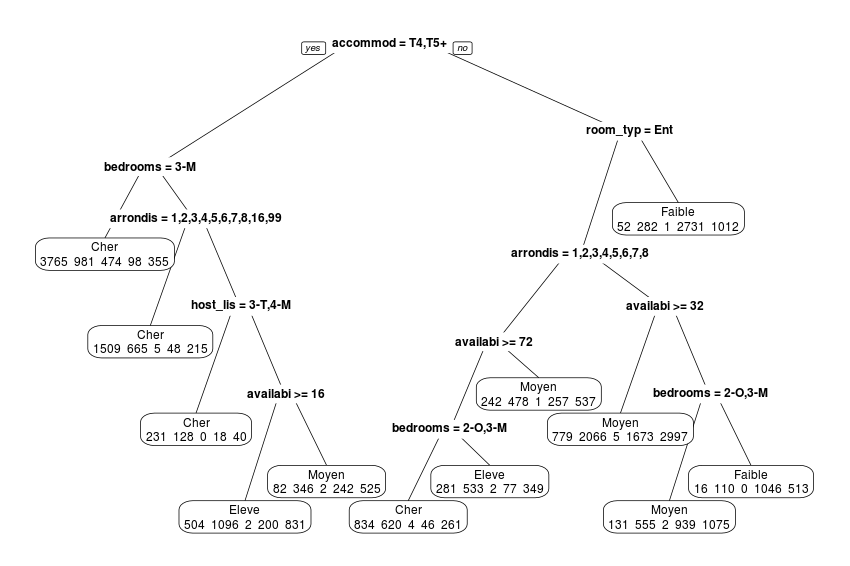

In [25]:
%%R -w 30 -h 20 -u cm
prp(AirbnbTree,extra=1)


In [69]:
%%R
jpeg("/home/user/Documents/STA211-Datamining/Projet_STA/Tree_price_level1.jpg", width=700, height=1000)
plot.new()
prp(AirbnbTree,extra=1)
title(main="Arbre de décision sur Price_level", cex.main=3, line=1)

dev.off()

png 
  2 


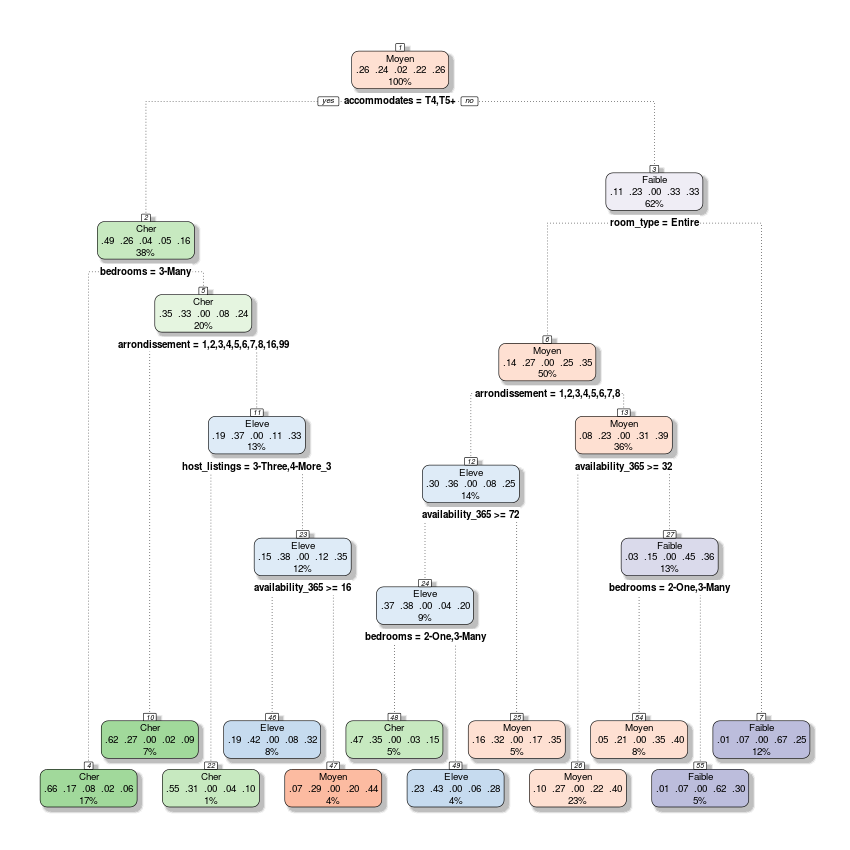

In [28]:
%%R -w 30 -h 30 -u cm
library(RColorBrewer)
library(rattle)
fancyRpartPlot(AirbnbTree, sub = '')


In [79]:
%%R
library(RColorBrewer)
library(rattle)
jpeg("/home/user/Documents/STA211-Datamining/Projet_STA/Tree_price_level2.jpg", width=700, height=1000,quality=100)
plot.new()
fancyRpartPlot(AirbnbTree, sub = '')
title(main="Arbre de décision sur Price_level", cex.main=3, line=1)

dev.off()

png 
  2 


cex 0.738   xlim c(0, 1)   ylim c(-0.1, 1.1)


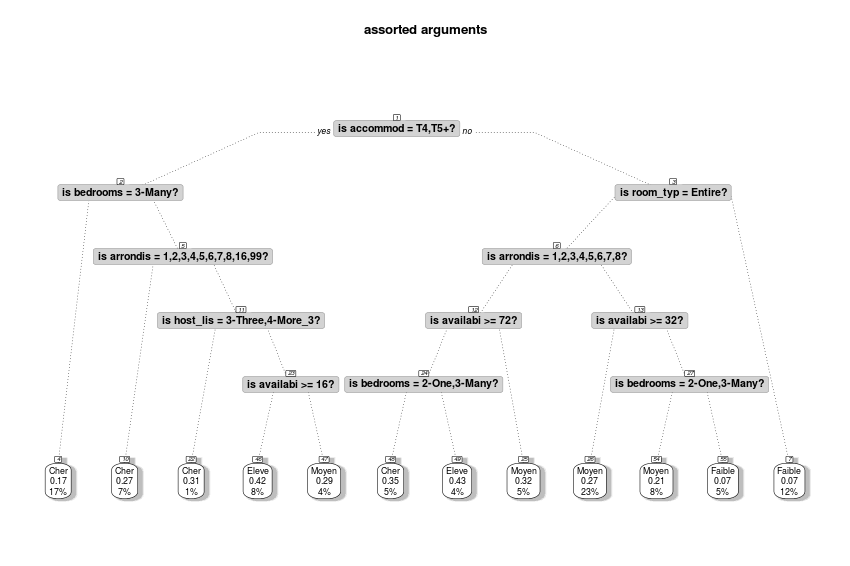

In [29]:
%%R -w 30 -h 20 -u cm
prp(AirbnbTree, main="assorted arguments",
    extra=106,           # display prob of survival and percent of obs
    nn=TRUE,             # display the node numbers
    fallen.leaves=TRUE,  # put the leaves on the bottom of the page
    shadow.col="gray",   # shadows under the leaves
    branch.lty=3,        # draw branches using dotted lines
    branch=.5,           # change angle of branch lines
    faclen=0,            # faclen=0 to print full factor names
    trace=1,             # print the automatically calculated cex
    split.cex=1.2,       # make the split text larger than the node text
    split.prefix="is ",  # put "is " before split text
    split.suffix="?",    # put "?" after split text
#    col=cols, border.col=cols,   # green if survived
    split.box.col="lightgray",   # lightgray split boxes (default is white)
    split.border.col="darkgray", # darkgray border on split boxes
    split.round=.5)              # round the split box corners a tad

## Arbre de régression sur le prix total

In [4]:
%%R
library(rpart)
library(rpart.plot)
suppressPackageStartupMessages(library(jsonlite))
suppressPackageStartupMessages(library(Hmisc))

# Rechargemet du jeu de données pour récupérer la variable total_price
path="/home/user/Documents/STA211-Datamining/Projet_STA/"
Airbnb<-fromJSON(paste(path,"airbnb_V3.json",sep=""))
sapply(Airbnb,class)
character_vars <- lapply(Airbnb, class) == "character"
Airbnb[, character_vars] <- lapply(Airbnb[, character_vars], as.factor)
#définition de la variable arrondissement comme qualitative
Airbnb$arrondissement <- as.factor(Airbnb$arrondissement ) 
sapply(Airbnb,class)
Airbnb <- subset(Airbnb, select = -c(price_level) )


In [44]:
%%R
AirbnbTree <- rpart(total_price~.,data=Airbnb[2:28],control=rpart.control(minsplit=50,cp = 0.003, xval=20))
printcp(AirbnbTree)


Regression tree:
rpart(formula = total_price ~ ., data = Airbnb[2:28], control = rpart.control(minsplit = 50, 
    cp = 0.003, xval = 20))

Variables actually used in tree construction:
[1] accommodates     arrondissement   availability_365 availability_60 
[5] bathrooms        bedrooms         host_listings    room_type       

Root node error: 312836472/41094 = 7612.7

n= 41094 

          CP nsplit rel error  xerror     xstd
1  0.2755030      0   1.00000 1.00009 0.024482
2  0.1136717      1   0.72450 0.72468 0.019404
3  0.0398153      2   0.61083 0.61116 0.016236
4  0.0257536      3   0.57101 0.57138 0.016170
5  0.0169902      4   0.54526 0.54674 0.015620
6  0.0152413      5   0.52827 0.53132 0.015580
7  0.0137939      6   0.51302 0.51610 0.015521
8  0.0082931      7   0.49923 0.50232 0.015535
9  0.0079877      8   0.49094 0.49655 0.015320
10 0.0067910      9   0.48295 0.48846 0.014928
11 0.0062492     10   0.47616 0.48652 0.014843
12 0.0060474     11   0.46991 0.47792 0.014887
13 

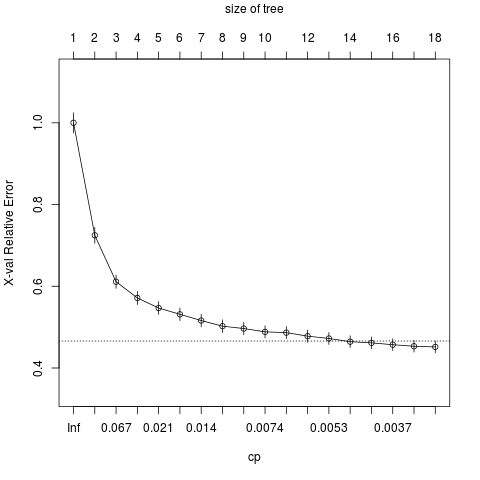

In [45]:
%%R
plotcp(AirbnbTree)

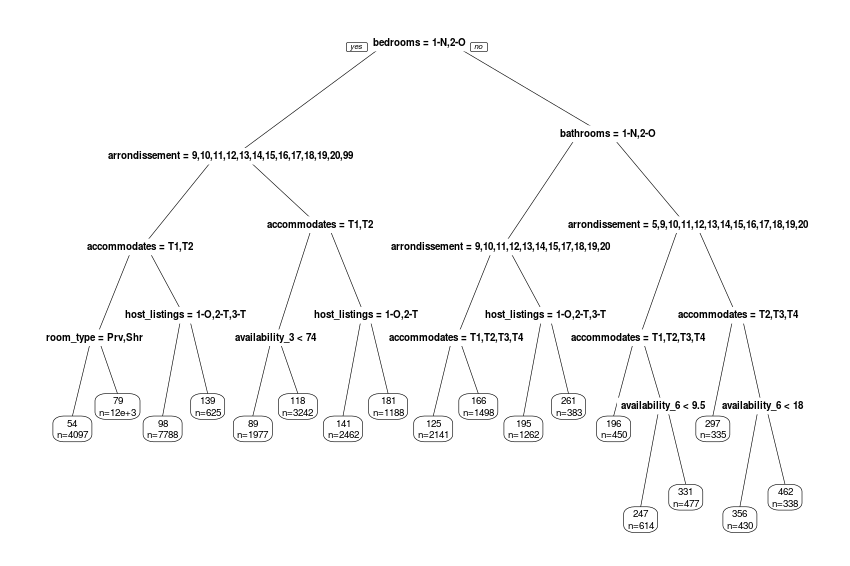

In [46]:
%%R -w 30 -h 20 -u cm
prp(AirbnbTree,extra=1)

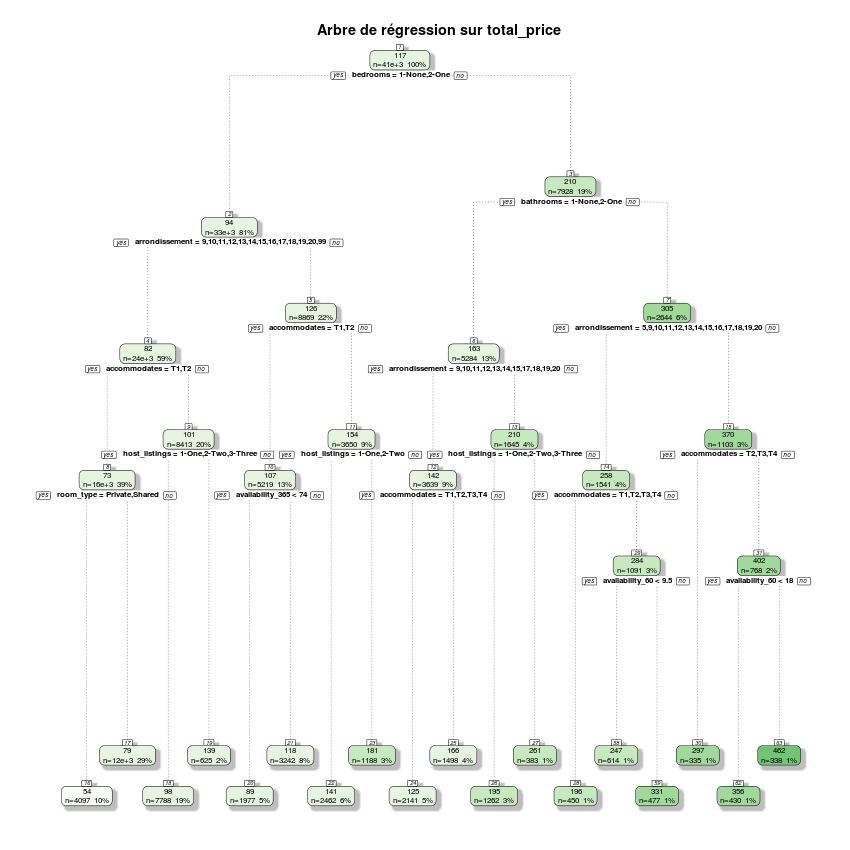

In [47]:
%%R -w 30 -h 30 -u cm
library(RColorBrewer)
library(rattle)

fancyRpartPlot(AirbnbTree, main = 'Arbre de régression sur total_price',yesno=2,sub='')

In [48]:
%%R
library(RColorBrewer)
library(rattle)
jpeg("/home/user/Documents/STA211-Datamining/Projet_STA/Tree_total_price.jpg", width=1000, height=1000,quality=100)
plot.new()
fancyRpartPlot(AirbnbTree, main = 'Arbre de régression sur total_price',yesno=2,sub='')

dev.off()

png 
  2 


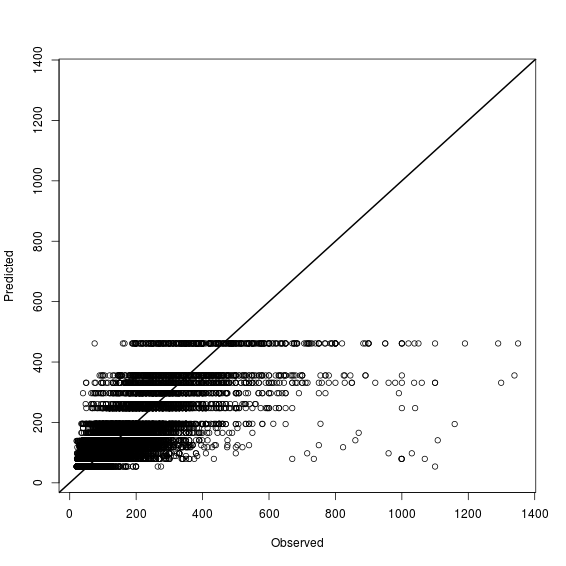

In [49]:
%%R -w 20 -h 20 -u cm
Airbnb_pred <- predict(AirbnbTree, newdata = Airbnb)
xlim <- range(Airbnb$total_price)
ylim <- range(Airbnb_pred)
plot(Airbnb_pred ~ total_price, data = Airbnb, xlab = "Observed",  ylab = "Predicted", ylim = xlim, xlim = xlim)
abline(a = 0, b = 1,lwd=2)

## RandomForest sur price_level

In [75]:
%%R
library(jsonlite)
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(dplyr))
#Chargement du jeu de données
path="/home/user/Documents/STA211-Datamining/Projet_STA/"
Airbnb<-fromJSON(paste(path,"airbnb_V3.json",sep=""))
sapply(Airbnb,class)
character_vars <- lapply(Airbnb, class) == "character"
Airbnb[, character_vars] <- lapply(Airbnb[, character_vars], as.factor)
#définition de la variable arrondissement comme qualitative
Airbnb$arrondissement <- as.factor(Airbnb$arrondissement ) 
sapply(Airbnb,class)
Airbnb <- subset(Airbnb, select = -c(total_price) )
#Pour des problèmes de mémoire, je lance la forêt alétoire sur un échantillon de 30%
set.seed(123)
Airbnb_train <- Airbnb %>% sample_frac(0.3)


In [73]:
%%R
AirbnbRF <- randomForest(price_level~.,Airbnb_train[2:28], na.action = na.roughfix)
print(AirbnbRF)


Call:
 randomForest(formula = price_level ~ ., data = Airbnb_train[2:28],      na.action = na.roughfix) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 44.49%
Confusion matrix:
           Cher Eleve Exorbitant Faible Moyen class.error
Cher       2322   548         11     31   219   0.2583839
Eleve       668  1131          0    192   909   0.6100000
Exorbitant  153     1         33      0     4   0.8272251
Faible       43   163          0   1736   881   0.3850514
Moyen       183   697          0    782  1621   0.5062443


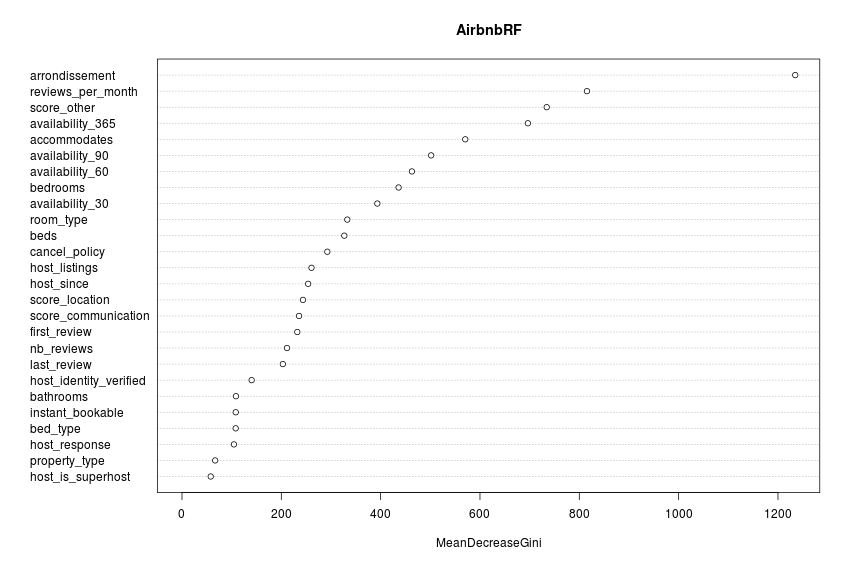

In [66]:
%%R -w 30 -h 20 -u cm
varImpPlot(AirbnbRF)

In [37]:
%%R
Airbnb_train2 <- Airbnb %>% sample_frac(0.4)
AirbnbRF2 <- randomForest(price_level~.,Airbnb_train2[2:28], ntree=1500, mtry=2, na.action = na.roughfix)
print(AirbnbRF2)


Call:
 randomForest(formula = price_level ~ ., data = Airbnb_train2[2:28],      ntree = 1500, mtry = 2, na.action = na.roughfix) 
               Type of random forest: classification
                     Number of trees: 1500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 44.34%
Confusion matrix:
           Cher Eleve Exorbitant Faible Moyen class.error
Cher       3235   637          3     35   340   0.2388235
Eleve      1031  1305          0    233  1345   0.6665815
Exorbitant  260     1          9      2     4   0.9673913
Faible       50   141          0   2233  1208   0.3851872
Moyen       308   757          0    933  2368   0.4576271


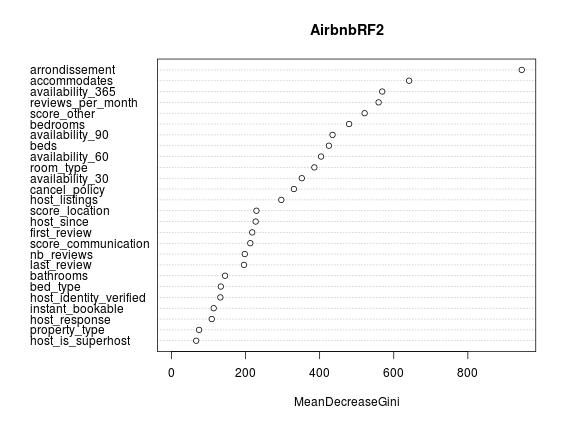

In [38]:
%%R -w 20 -h 15 -u cm
varImpPlot(AirbnbRF2)

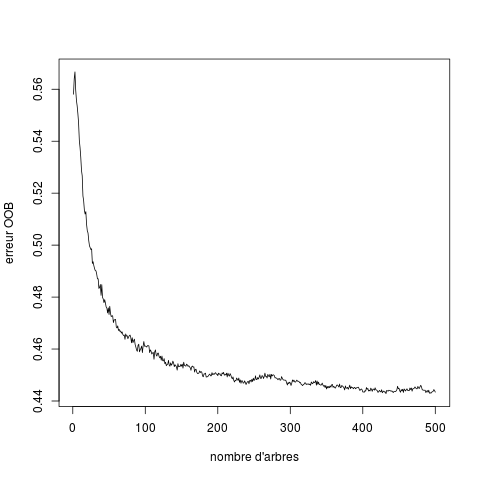

In [34]:
%%R
plot(AirbnbRF2$err.rate[, 1], type = "l", xlab = "nombre d'arbres", ylab = "erreur OOB")

In [35]:
%%R
AirbnbRF3 <- randomForest(price_level~.,Airbnb_train2[2:28], ntree=5000, mtry=2, na.action = na.roughfix)
print(AirbnbRF3)


Call:
 randomForest(formula = price_level ~ ., data = Airbnb_train2[2:28],      ntree = 5000, mtry = 2, na.action = na.roughfix) 
               Type of random forest: classification
                     Number of trees: 5000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 43.82%
Confusion matrix:
           Cher Eleve Exorbitant Faible Moyen class.error
Cher       3271   612          1     34   355   0.2344957
Eleve      1045  1258          0    258  1372   0.6801424
Exorbitant  230     1          4      1     6   0.9834711
Faible       56   137          0   2291  1172   0.3733589
Moyen       292   726          0    905  2411   0.4437010


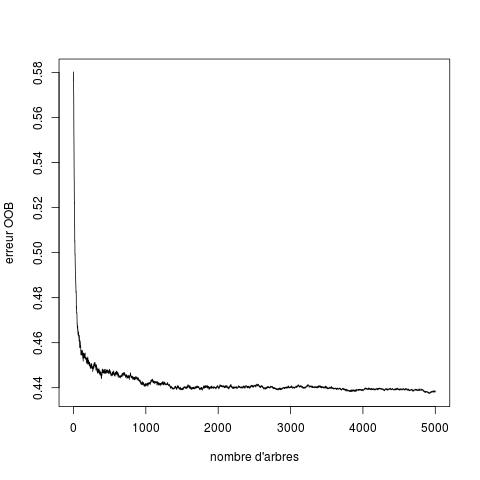

In [36]:
%%R
plot(AirbnbRF3$err.rate[, 1], type = "l", xlab = "nombre d'arbres", ylab = "erreur OOB")

In [71]:
%%R
set.seed(123)
library(caret)
Airbnb_train2 <- na.omit(Airbnb_train2)
mod <- train(price_level ~ ., data = Airbnb_train2[2:28], method = "rf")
print(mod)

Random Forest 

16436 samples
   26 predictor
    5 classes: 'Cher', 'Eleve', 'Exorbitant', 'Faible', 'Moyen' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 16436, 16436, 16436, 16436, 16436, 16436, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.5277089  0.3684205
  32    0.5243548  0.3679443
  63    0.5188818  0.3608730

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


In [78]:
%%R
#recodage price_level
#21€ à 80€=> Faible, 81€ à 120€ => moyen, 120à 300€ Elevé et plus de 300€ => Cher
Airbnb<-fromJSON(paste(path,"airbnb_V4.json",sep=""))
sapply(Airbnb,class)
character_vars <- lapply(Airbnb, class) == "character"
Airbnb[, character_vars] <- lapply(Airbnb[, character_vars], as.factor)
#définition de la variable arrondissement comme qualitative
Airbnb$arrondissement <- as.factor(Airbnb$arrondissement ) 
sapply(Airbnb,class)
Airbnb <- subset(Airbnb, select = -c(total_price) )
#Pour des problèmes de mémoire, je lance la forêt alétoire sur un échantillon de 30%
set.seed(123)
Airbnb_train <- Airbnb %>% sample_frac(0.3)

In [79]:
%%R
Airbnb_train3 <- Airbnb %>% sample_frac(0.4)
AirbnbRF4 <- randomForest(price_level ~ .,Airbnb_train3[2:28], ntree=1500, mtry=2, na.action = na.roughfix)
print(AirbnbRF4)


Call:
 randomForest(formula = price_level ~ ., data = Airbnb_train3[2:28],      ntree = 1500, mtry = 2, na.action = na.roughfix) 
               Type of random forest: classification
                     Number of trees: 1500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 35.72%
Confusion matrix:
       Cher Eleve Faible Moyen class.error
Cher    107   486      9     8   0.8245902
Eleve    22  3440    524   671   0.2613270
Faible    0   261   5746   673   0.1398204
Moyen     0  1168   2049  1274   0.7163215
